## Imports

In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

# Data

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

x_train

,study_hours,class_attendance,facility_rating,gender,coaching,self_study
1156,5.57,43.4,2,1,0,1
1536,3.52,61.1,2,0,1,0
5035,1.83,58.6,1,0,0,0
9040,7.17,44.1,1,1,1,0
7272,5.06,86.1,2,1,1,0
...,...,...,...,...,...,...
11964,0.39,58.0,0,1,0,0
5191,2.44,74.7,2,0,0,1
5390,0.90,92.3,2,0,0,0
860,7.51,72.8,2,1,1,0


# Models

In [3]:
PATH = 'pipes'
pipe_names = os.listdir(PATH)[:-1] #Gitignore file to not pushing the models
pipe_names = [n.strip('.pkl') for n in pipe_names]

pipes = {}

for name in pipe_names:
    with open(os.path.join(PATH, name + '.pkl'), 'rb') as f:
        pipes[name] = pickle.load(f)

pipes

{'XSB': Pipeline(steps=[('sclaer', StandardScaler()),
                 ('regressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7555702646479975, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.007669548993428671, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3, max_leaves=None,
                               min_child_weight=3, mis

# Friedman test

## Results for testing
Bootstrap

In [4]:
import numpy as np
from sklearn.metrics import r2_score

results = {n: [] for n in pipe_names}

idx = np.arange(0, x_train.shape[0])
for i in range(10):
    print("Iteration:", i+1)
    Boot_idx = np.random.choice(idx, size=int(10e3), replace=True, p=None)
    x_boot, y_boot = x_train.iloc[Boot_idx], y_train.iloc[Boot_idx]
    for p_idx, model in enumerate(pipes.values()):

        model.fit(x_boot, y_boot)
        preds = model.predict(x_test)
        score = r2_score(y_test, preds)

        results[pipe_names[p_idx]].append(score)


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


,0,1,2,3,4,5,6,7,8,9
XSB,0.653013,0.652863,0.653821,0.652503,0.652852,0.655171,0.655440,0.651337,0.654119,0.651626
Tree,0.601096,0.598361,0.605446,0.597834,0.599768,0.597935,0.603054,0.600863,0.596678,0.594586
SVR,0.650159,0.652100,0.651146,0.650030,0.651149,0.653415,0.651335,0.649637,0.650575,0.648314
Forest,0.638960,0.635342,0.640881,0.635212,0.638945,0.640959,0.639925,0.637655,0.638460,0.636453
Linear,0.655653,0.658030,0.658535,0.657584,0.658257,0.658412,0.658483,0.658617,0.658546,0.655337


# Friedman Test

In [5]:
from scipy.stats import friedmanchisquare

# Extract the lists from the dictionary
model_results = [results[i] for i in results]

# Run the test
stat, p = friedmanchisquare(*model_results)

print(stat)
print(f"P-value: {p}")

40.0
P-value: 4.328422607120966e-08


# Nemenyi Test
We need perform another test as the p-value in fridman test is low enough to reject null hypothesis

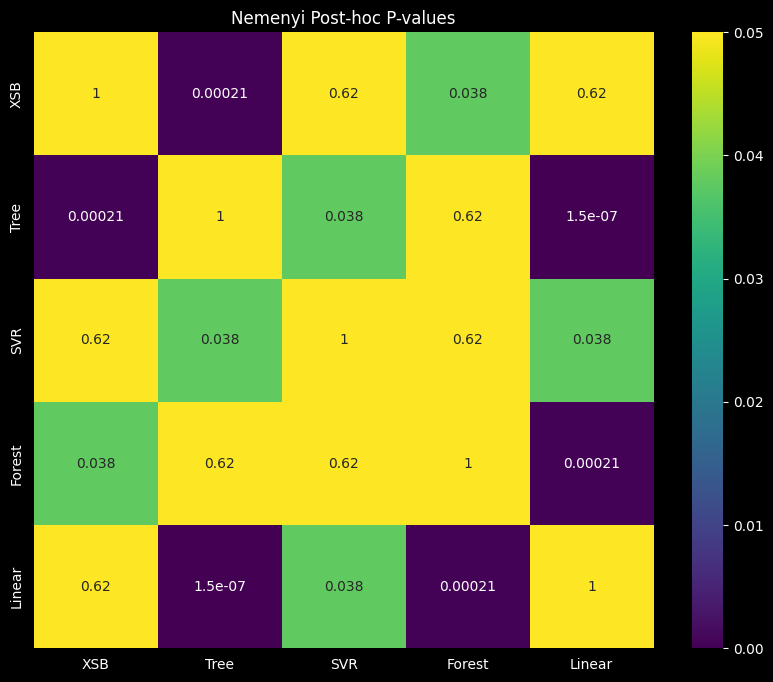

In [6]:
import scikit_posthocs as sp
import seaborn as sns

nemenyi_results = sp.posthoc_nemenyi_friedman(results_df.T)

plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap='viridis', vmin=0, vmax=0.05)
plt.title("Nemenyi Post-hoc P-values")
plt.show()

# Means of Model Results

In [7]:
results_df.mean(axis=1)

XSB       0.653275
Tree      0.599562
SVR       0.650786
Forest    0.638279
Linear    0.657746
dtype: float64